In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

# Architecture of Diff Components

---



In [ ]:
class Embedding(nn.Module):

    def __init__(self, embed_dict_len, embed_size, device):
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(embed_dict_len, embed_size, device=device)

    def forward(self, word_idxs):
                                            # Here word_idxs should be (batch_size, seq_len)
        embeddings = self.embed(word_idxs)  # (batch_size, seq_len, embed_size)

        return embeddings

class RNNEncoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, bidirectional):
        super(RNNEncoder, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)    ### BATCH_FIRST

    def forward(self, x):

        y, _ = self.rnn(x)  # (batch_size, seq_len, 2*hidden_size)

        return y

class NeuralNet(nn.Module):

    def __init__(self, hidden_size, device):
        super(NeuralNet, self).__init__()
        self.layer_stack = nn.Sequential(
              nn.Linear(2*hidden_size, 2*hidden_size, device=device),
              nn.ReLU(),
              nn.Linear(2*hidden_size, 1, device=device)
        )

    def forward(self, q):
        logits = self.layer_stack(q) # (bs, q_len, 1)
        return logits

class Attention(nn.Module):

    def __init__(self, hidden_size, device):
        super(Attention, self).__init__()
        self.q_attender = NeuralNet(hidden_size, device=device)

    def forward(self, c, q):
        batch_size, c_len, _ = c.shape # was size()  c and q are (bs, c_len or q_len, 2*hid_size)
        q_len = q.size(1)
        logits_q = self.q_attender(q)
        alphas_q = F.softmax(logits_q, dim=1).squeeze().unsqueeze(1) # (bs, 1, q_len)

        # (bs, 1, q_len) x (bs, q_len, 2*hid_size) => (bs, 1, 2*hid_size)
        attended_q = torch.bmm(alphas_q, q)

        logits_c = torch.bmm(c, attended_q.squeeze().unsqueeze(2))  # (bs, c_len, 1)
        alphas_c = F.softmax(logits_c, dim=1).squeeze().unsqueeze(1)  # (bs, 1, c_len)

        # (bs, 1, c_len) x (bs, c_len, 2*hid_size) => (bs, 1, 2*hid_size)
        attended_c = torch.bmm(alphas_c, c)


        attended = torch.cat([attended_q.expand(-1, c_len, -1), c, attended_c.expand(-1, c_len, -1)], dim=2) # (bs, c_len, 6*hid_size)

        return attended



class Output(nn.Module):

    def __init__(self, hidden_size):
        super(Output, self).__init__()

        self.outRnn = RNNEncoder(input_size=6*hidden_size,
                              hidden_size=2,
                              num_layers=2, bidirectional=False)

    def forward(self, attended):
        out = self.outRnn(attended)   # (bs, c_len, 2)
        logits_1, logits_2 = out[:,:,0], out[:,:,1]  # (batch_size, seq_len)

        # Shapes: (batch_size, seq_len)
        # p1 = F.softmax(logits_1.squeeze(), dim=1)
        # p2 = F.softmax(logits_2.squeeze(), dim=1)                                 # EXPLICITLY INCLUDED THE DIM ARGUMENT: NOT CHECKED

        return logits_1, logits_2


# Defining the Model

In [ ]:
class Model(nn.Module):
    """Follows a high-level structure commonly found in SQuAD models:
        - Embedding layer: Embed word indices to get word vectors.
        - Encoder layer: Encode the embedded sequence.
        - Attention layer: Apply an attention mechanism to the encoded sequence.
        - Output layer: Simple layer (e.g., linear + softmax) and also an LSTM RNN to get final outputs.
    Args:
        word_vectors (torch.Tensor): Pre-trained word vectors.                   ### Not in this case
        hidden_size (int): Number of features in the hidden state at each layer.
    """
    def __init__(self, hidden_size, embed_dict_size, embed_size, device):
        super(Model, self).__init__()

        # self.emb_q = Embedding(embed_dict_size, embed_size)
        self.emb = Embedding(embed_dict_size, embed_size, device=device)

        self.enc_q = RNNEncoder(input_size=embed_size,
                                     hidden_size=hidden_size,
                                     num_layers=2, bidirectional=True)

        self.enc_c = RNNEncoder(input_size=embed_size,
                                     hidden_size=hidden_size,
                                     num_layers=2, bidirectional=True)
        self.attender = NeuralNet(hidden_size=hidden_size, device=device)

        self.att = Attention(hidden_size=hidden_size, device=device)

        self.out = Output(hidden_size=hidden_size)

    def forward(self, cw_idxs, qw_idxs):
        # print("ccww",cw_idxs)
        # print("qqww",qw_idxs)
        cw_embed = self.emb(cw_idxs)  # (batch_size, c_len, embed_size)

        qw_embed = self.emb(qw_idxs)  # (batch_size, q_len, embed_size)
        # print(qw_embed)
        c_enc = self.enc_c(cw_embed)    # (batch_size, c_len, 2*hidden_size)
        q_enc = self.enc_q(qw_embed)     # (batch_size, q_len, 2*hidden_size)
        # print("enc",q_enc)
        attended = self.att(c_enc, q_enc)  # (bs, c_len, 6*hidden_size)
        # print()
        out = self.out(attended)  # 2 tensors, each (batch_size, c_len)
        # print("out",out)
        return out


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Data Loading

In [ ]:
# ### DATA LOADING

# import os
# import tqdm
# import json
# import zipfile
# import tarfile
# import pickle
# import numpy as np
# import urllib.request

# filepath = '/content/gdrive/My Drive/train-v2.0.json'
# with open(filepath) as f:
#     data = json.load(f)

# from spacy.lang.en import English
# tokenizer = English()

# def word_tokenize(sent):
#     return [token.text for token in tokenizer(sent)]

# def clean_text(text):
#     text = text.replace("]", " ] ")
#     text = text.replace("[", " [ ")
#     text = text.replace("\n", " ")
#     text = text.replace("''", '" ').replace("``", '" ')

#     return text

# def convert_idx(text, tokens):
#     current = 0
#     spans = []
#     for token in tokens:
#         current = text.find(token, current)
#         if current < 0:
#             print("Token {} cannot be found".format(token))
#             raise Exception()
#         spans.append((current, current + len(token)))
#         current += len(token)
#     return spans

# # these lists contain arrays, where each array contains tokens
# # context_file[i] will correspond to question_file[i] etc, and a token is a word
# context_file = []
# question_file = []
# answer_file = []
# labels_file = []

# quesCount = {"Who":0,"What":0,"When":0,"Where":0}
# lenCount = dict()


# for article_id in tqdm.tqdm(range(len(data['data']))):
#     list_paragraphs = data['data'][article_id]['paragraphs']
#     # loop over the paragraphs
#     for paragraph in list_paragraphs:
#         context = paragraph['context']
#         context = clean_text(context)
#         context_tokens = [w for w in word_tokenize(context) if w]
#         spans = convert_idx(context, context_tokens)
#         qas = paragraph['qas']
#         # loop over Q/A
#         for qa in qas:
#             question = qa['question']
#             question = clean_text(question)
#             question_tokens = [w for w in word_tokenize(question) if w]
#             # if str(question_tokens[0]) in quesCount:
#             #     quesCount[str(question_tokens[0])]+=1
#             # elif len(question_tokens)>1 and str(question_tokens[1]) in quesCount:
#             #     quesCount[str(question_tokens[1])]+=1
#             factoid = False

#             for qtype in quesCount:
#                 if qtype in question_tokens:
#                     factoid = True
#                     quesCount[qtype]+=1
#                 elif (qtype.lower()) in question_tokens:
#                     factoid = True
#                     quesCount[qtype]+=1

#             if not factoid:
#                 continue

#             if len(question_tokens) in lenCount:
#                 lenCount[len(question_tokens)]+=1
#             else:
#                 lenCount[len(question_tokens)]=1
#             # select only one ground truth, the top answer, if any answer
#             answer_ids = 1 if qa['answers'] else 0
#             labels = []
#             if answer_ids:
#                 # for answer_id in range(answer_ids):
#                 answer_id = 0
#                 answer = qa['answers'][answer_id]['text']
#                 answer = clean_text(answer)
#                 answer_tokens = [w for w in word_tokenize(answer) if w]
#                 if len(answer_tokens)>9:
#                     continue
#                 answer_start = qa['answers'][answer_id]['answer_start']
#                 answer_stop = answer_start + len(answer)
#                 answer_span = []
#                 for idx, span in enumerate(spans):
#                     if not (answer_stop <= span[0] or answer_start >= span[1]):
#                         answer_span.append(idx)
#                 if not answer_span:
#                     continue
#                 labels.append([answer_span[0], answer_span[-1]])
#                 # labels.append(str(answer_span[0]) + ' ' + str(answer_span[-1]))

#                 context_file.append([token for token in context_tokens])
#                 question_file.append([token for token in question_tokens])
#                 answer_file.append([token for token in answer_tokens])
#                 labels_file.append(labels)



In [ ]:
# ### replace the tokenized words with their associated ID in the vocabulary

# with open('/content/gdrive/My Drive/word2idx.json','rb') as e:
#     word2idx_dict = json.load(e)


# context_idxs = []
# question_idxs = []
# for i, (c, q) in tqdm.tqdm(enumerate(zip(context_file, question_file))):

#     len_c, len_q = len(c), len(q)
#     # create empty numpy arrays
#     context_idx = np.zeros([len_c], dtype=np.int32)
#     question_idx = np.zeros([len_q], dtype=np.int32)

#     # replace 0 values with word and char IDs
#     for j, word in enumerate(c):
#         context_idx[j] = word2idx_dict[word]

#     context_idxs.append(context_idx)

#     for j, word in enumerate(q):
#         question_idx[j] = word2idx_dict[word]

#     question_idxs.append(question_idx)

In [ ]:

#np.savez('/content/gdrive/My Drive/data.npz', context=context_idxs, question=question_idxs, label=labels_file)

# Some essential presuppositions

In [ ]:
### Some essential hyper params
embedding_size = 400
hidden_size = embedding_size//2

batch_size = 32
learning_rate = 1e-4

MODEL_PATH = '/content/gdrive/My Drive/qa_model.tar'


### LOADING THE VOCAB_DICT
import json

with open('/content/gdrive/My Drive/idx2word.json','rb') as f:
    idx2word_dict = json.load(f)

embed_dict_size = len(idx2word_dict)

### MODEL INSTANTIATION
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


model = Model(hidden_size, embed_dict_size, embedding_size, device).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

Using cuda device


In [ ]:
import numpy as np

data = np.load('/content/gdrive/My Drive/data.npz', allow_pickle=True)
context_idxs = data['context']
question_idxs = data['question']
labels_file = data['label']

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset): # inherited Dataset
    def __init__(self, context_file, question_file, labels_file):
        self.contexts = context_file
        self.questions = question_file
        #self.answers = answer_file
        self.labels = labels_file

    def __len__(self):
        return len(self.questions)

    def __getitem__(self,idx):
        return torch.FloatTensor(self.contexts[idx]), torch.FloatTensor(self.questions[idx]), torch.FloatTensor(self.labels[idx]) ## CAN CHANGE IF WANTED


from torch.nn.utils.rnn import *

def pad_collate(batch):
  (xx1, xx2, yy) = zip(*batch)
  x1_lens = [len(x) for x in xx1]
  x2_lens = [len(x) for x in xx2]
  y_lens = [len(y) for y in yy]

  xx1_pad = pad_sequence(xx1, batch_first=True, padding_value=0)
  xx2_pad = pad_sequence(xx2, batch_first=True, padding_value=0)
  yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)

  return xx1_pad, xx2_pad, yy_pad, x1_lens, x2_lens, y_lens

dataset = CustomDataset(context_idxs,question_idxs,labels_file)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

In [ ]:
question_idxs[56000]

array([  641,   991,    43, 36779, 37201,  7564,  2019], dtype=int32)

In [ ]:
len(data_loader)

2010

In [ ]:
for batch in data_loader:
    print(batch[1])
    print(batch[1].shape)
    # print(batch[2].transpose(0,2)[1].transpose(0,1).squeeze())
    #print(batch[2].squeeze().transpose(0,1)[0])
    break

tensor([[1.6656e+04, 1.7000e+02, 4.3000e+01, 3.6140e+03, 4.7000e+01, 4.3000e+01,
         3.5582e+04, 2.3000e+01, 9.7309e+04, 1.5640e+04, 2.0190e+03, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.6656e+04, 1.6000e+01, 1.0323e+04, 2.8000e+01, 5.4255e+04, 8.4390e+03,
         2.8000e+01, 2.0190e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.2900e+03, 4.2810e+03, 4.7000e+01, 1.6300e+02, 1.7000e+02, 7.1600e+02,
         2.8000e+01, 3.3460e+03, 5.8610e+03, 2.0190e+03, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [6.4100e+02, 9.91

# Training Loop

In [ ]:
# print("Starting training...")
# losses = []
# num_epochs = 5

# for epoch in range(num_epochs):
#     print("##### epoch {:2d}".format(epoch + 1))
#     model.train()
#     train_losses = 0
#     for batch in data_loader:
#         cw_idxs, qw_idxs, label1, label2 =                          torch.Tensor(batch[0]).long().to(device), \
#                                                                        torch.Tensor(batch[1]).long().to(device), \
#                                                                        torch.Tensor(batch[2].transpose(0,2)[0].transpose(0,1).squeeze()).long().to(device), \
#                                                                        torch.Tensor(batch[2].transpose(0,2)[1].transpose(0,1).squeeze()).long().to(device)

#         optimizer.zero_grad()
#         pred1, pred2 = model(cw_idxs, qw_idxs)
#         loss = criterion(pred1, label1) + criterion(pred2, label2)           # label1, label2 one hot? NOT NEEDED
#         #loss = loss/batch_size
#         train_losses += loss.item()                                           # Does loss add accross batches? YES IT TAKES THE MEAN

#         loss.backward()
#         optimizer.step()

#     losses.append(train_losses)
#     # for name, param in model.named_parameters():
#     #     print(f'{name}.grad', param.grad)
#     print("Training loss of the model at epoch {} is: {}".format(epoch + 1, int(train_losses)))


# Saving the model

In [ ]:
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             'losses': losses,
#             }, MODEL_PATH)


# Alternative Training Loop

In [ ]:
# print("Starting training...")
# losses = []
# epoch = 0
# loss = 0

# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             'losses': losses,
#             }, MODEL_PATH)


In [ ]:
print("Resuming training...")

while True:
    checkpoint = torch.load(MODEL_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    losses = checkpoint['losses']

    print("##### epoch {:2d}".format(epoch + 1))
    model.train()
    train_losses = 0
    for batch in data_loader:
        cw_idxs, qw_idxs, label1, label2 =                          torch.Tensor(batch[0]).long().to(device), \
                                                                       torch.Tensor(batch[1]).long().to(device), \
                                                                       torch.Tensor(batch[2].transpose(0,2)[0].transpose(0,1).squeeze()).long().to(device), \
                                                                       torch.Tensor(batch[2].transpose(0,2)[1].transpose(0,1).squeeze()).long().to(device)

        optimizer.zero_grad()
        pred1, pred2 = model(cw_idxs, qw_idxs)
        loss = criterion(pred1, label1) + criterion(pred2, label2)           # label1, label2 one hot? NOT NEEDED
        #loss = loss/batch_size
        train_losses += loss.item()                                           # Does loss add accross batches? YES IT TAKES THE MEAN

        loss.backward()
        optimizer.step()


    print("Training loss of the model at epoch {} is: {}".format(epoch + 1, int(train_losses)))

    losses.append(train_losses)
    epoch += 1

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'losses': losses,
            }, MODEL_PATH)


Resuming training...
##### epoch 39
Training loss of the model at epoch 39 is: 16184
##### epoch 40
Training loss of the model at epoch 40 is: 16183
##### epoch 41
Training loss of the model at epoch 41 is: 16151
##### epoch 42


KeyboardInterrupt: ignored

In [ ]:
# for name, param in model.named_parameters():
#         print(f'{name}.grad', param.grad)


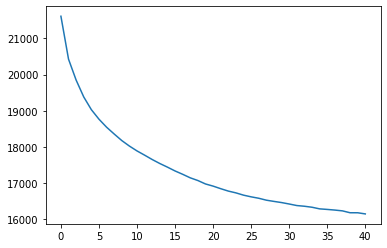

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

# Prediction

### Demo

In [ ]:
context = """During the Cold War, American troops and their allies fought Communist forces in Korea and Vietnam.
The Korean War began in 1950, when the Soviets walked out of a U.N. Security meeting, removing their possible veto."""
question = "When did the american troops fight vietnamese communist forces?"


import json
import numpy as np

from spacy.lang.en import English
tokenizer = English()

def word_tokenize(sent):
    return [token.text for token in tokenizer(sent)]

def clean_text(text):
    text = text.replace("]", " ] ")
    text = text.replace("[", " [ ")
    text = text.replace("\n", " ")
    text = text.replace("''", '" ').replace("``", '" ')

    return text

context = clean_text(context)
context_tokens = [w for w in word_tokenize(context) if w]

question = clean_text(question)
question_tokens = [w for w in word_tokenize(question) if w]

### replace the tokenized words with their associated ID in the vocabulary

with open('/content/gdrive/My Drive/word2idx.json','rb') as e:
    word2idx_dict = json.load(e)


context_idxs = []
question_idxs = []
len_c, len_q = len(context_tokens), len(question_tokens)
# create empty numpy arrays
context_idx = np.zeros([len_c], dtype=np.int32)
question_idx = np.zeros([len_q], dtype=np.int32)

# replace 0 values with word IDs
for j, word in enumerate(context_tokens):
   try:
     context_idx[j] = word2idx_dict[word]
   except KeyError:
     context_idx[j] = 0


for j, word in enumerate(question_tokens):
   try:
     question_idx[j] = word2idx_dict[word]
   except KeyError:
     question_idx[j] = 0

model.eval()
with torch.no_grad():
    pred1, pred2 = model(torch.Tensor(np.array([context_idx, context_idx])).long().to(device), torch.Tensor(np.array([question_idx, question_idx])).long().to(device))
    start, end = torch.argmax(pred1, dim=1)[0].item(), torch.argmax(pred2, dim=1)[0].item()

answer = ''
for index in range(start, end+1):
    answer = answer + context_tokens[index] + ' '

print(answer)

if answer == '':
    print('answer not found.')

1950 


In [ ]:
context = "New Delhi is the capital of India. It has a population of nearly three crore. It is a beautiful city."
question = "Which is a beautiful city?"


import json
import numpy as np

from spacy.lang.en import English
tokenizer = English()

def word_tokenize(sent):
    return [token.text for token in tokenizer(sent)]

def clean_text(text):
    text = text.replace("]", " ] ")
    text = text.replace("[", " [ ")
    text = text.replace("\n", " ")
    text = text.replace("''", '" ').replace("``", '" ')

    return text

context = clean_text(context)
context_tokens = [w for w in word_tokenize(context) if w]

question = clean_text(question)
question_tokens = [w for w in word_tokenize(question) if w]

### replace the tokenized words with their associated ID in the vocabulary

with open('/content/gdrive/My Drive/word2idx.json','rb') as e:
    word2idx_dict = json.load(e)


context_idxs = []
question_idxs = []
len_c, len_q = len(context_tokens), len(question_tokens)
# create empty numpy arrays
context_idx = np.zeros([len_c], dtype=np.int32)
question_idx = np.zeros([len_q], dtype=np.int32)

# replace 0 values with word IDs
for j, word in enumerate(context_tokens):
   try:
     context_idx[j] = word2idx_dict[word]
   except KeyError:
     context_idx[j] = 0


for j, word in enumerate(question_tokens):
   try:
     question_idx[j] = word2idx_dict[word]
   except KeyError:
     question_idx[j] = 0

model.eval()
with torch.no_grad():
    pred1, pred2 = model(torch.Tensor(np.array([context_idx, context_idx])).long().to(device), torch.Tensor(np.array([question_idx, question_idx])).long().to(device))
    start, end = torch.argmax(pred1, dim=1)[0].item(), torch.argmax(pred2, dim=1)[0].item()

answer = ''
for index in range(start, end+1):
    answer = answer + context_tokens[index] + ' '

print(answer)

if answer == '':
    print('answer not found.')

Delhi 


In [ ]:
context = 'This is Doctor Kabir Rajdheer Singh. Topper of the board, topper of the college, topper of the university, he is the one with an impeccable academic record. But with respect to anger management he is a big zero. He is not a rebel without a cause.'
question = 'Who has anger management issues?'


import json
import numpy as np

from spacy.lang.en import English
tokenizer = English()

def word_tokenize(sent):
    return [token.text for token in tokenizer(sent)]

def clean_text(text):
    text = text.replace("]", " ] ")
    text = text.replace("[", " [ ")
    text = text.replace("\n", " ")
    text = text.replace("''", '" ').replace("``", '" ')

    return text

context = clean_text(context)
context_tokens = [w for w in word_tokenize(context) if w]

question = clean_text(question)
question_tokens = [w for w in word_tokenize(question) if w]

### replace the tokenized words with their associated ID in the vocabulary

with open('/content/gdrive/My Drive/word2idx.json','rb') as e:
    word2idx_dict = json.load(e)


context_idxs = []
question_idxs = []
len_c, len_q = len(context_tokens), len(question_tokens)
# create empty numpy arrays
context_idx = np.zeros([len_c], dtype=np.int32)
question_idx = np.zeros([len_q], dtype=np.int32)

# replace 0 values with word IDs
for j, word in enumerate(context_tokens):
   try:
     context_idx[j] = word2idx_dict[word]
   except KeyError:
     context_idx[j] = 0


for j, word in enumerate(question_tokens):
   try:
     question_idx[j] = word2idx_dict[word]
   except KeyError:
     question_idx[j] = 0

model.eval()
with torch.no_grad():
    pred1, pred2 = model(torch.Tensor(np.array([context_idx, context_idx])).long().to(device), torch.Tensor(np.array([question_idx, question_idx])).long().to(device))
    start, end = torch.argmax(pred1, dim=1)[0].item(), torch.argmax(pred2, dim=1)[0].item()

answer = ''
for index in range(start, end+1):
    answer = answer + context_tokens[index] + ' '

print(answer)

if answer == '':
    print('answer not found.')

Kabir 


In [ ]:
context = "Keeley Rebecca Hazell (born 18 September 1986) is an English model and actress. Hazell was a Page 3 girl and has worked with magazines such as FHM, Loaded, Nuts and Zoo Weekly. She has also made numerous television appearances and has focused on her acting career, appearing in films such as Horrible Bosses 2 (2014) and the streaming television series Ted Lasso (2020). "
question = "Who is Keeley Rebecca Hazell?"


import json
import numpy as np

from spacy.lang.en import English
tokenizer = English()

def word_tokenize(sent):
    return [token.text for token in tokenizer(sent)]

def clean_text(text):
    text = text.replace("]", " ] ")
    text = text.replace("[", " [ ")
    text = text.replace("\n", " ")
    text = text.replace("''", '" ').replace("``", '" ')

    return text

context = clean_text(context)
context_tokens = [w for w in word_tokenize(context) if w]

question = clean_text(question)
question_tokens = [w for w in word_tokenize(question) if w]

### replace the tokenized words with their associated ID in the vocabulary

with open('/content/gdrive/My Drive/word2idx.json','rb') as e:
    word2idx_dict = json.load(e)


context_idxs = []
question_idxs = []
len_c, len_q = len(context_tokens), len(question_tokens)
# create empty numpy arrays
context_idx = np.zeros([len_c], dtype=np.int32)
question_idx = np.zeros([len_q], dtype=np.int32)

# replace 0 values with word IDs
for j, word in enumerate(context_tokens):
   try:
     context_idx[j] = word2idx_dict[word]
   except KeyError:
     context_idx[j] = 0


for j, word in enumerate(question_tokens):
   try:
     question_idx[j] = word2idx_dict[word]
   except KeyError:
     question_idx[j] = 0

model.eval()
with torch.no_grad():
    pred1, pred2 = model(torch.Tensor(np.array([context_idx, context_idx])).long().to(device), torch.Tensor(np.array([question_idx, question_idx])).long().to(device))
    start, end = torch.argmax(pred1, dim=1)[0].item(), torch.argmax(pred2, dim=1)[0].item()

answer = ''
for index in range(start, end+1):
    answer = answer + context_tokens[index] + ' '

print(answer)

if answer == '':
    print('answer not found.')

2020 


In [ ]:
index = 0
for batch in data_loader:
  datapoint = batch
  break

cw_idxs, qw_idxs, label1, label2 =                          torch.Tensor(batch[0]).long().to(device), \
                                                                       torch.Tensor(batch[1]).long().to(device), \
                                                                       torch.Tensor(batch[2].transpose(0,2)[0].transpose(0,1).squeeze()).long().to(device), \
                                                                       torch.Tensor(batch[2].transpose(0,2)[1].transpose(0,1).squeeze()).long().to(device)
model.eval()
with torch.no_grad():
    pred1, pred2 = model(cw_idxs, qw_idxs)
    start, end = torch.argmax(pred1[index]), torch.argmax(pred2[index])


In [ ]:
print('predicted', start.item(), end.item())
print('actual', label1[index].item(), label2[index].item())

predicted 85 85
actual 16 16


## Picking good prediction

In [ ]:
model.eval()
max_overlap = 0
with torch.no_grad():
    for batch in data_loader:
            cw_idxs, qw_idxs, label1, label2 =                          torch.Tensor(batch[0]).long().to(device), \
                                                                       torch.Tensor(batch[1]).long().to(device), \
                                                                       torch.Tensor(batch[2].transpose(0,2)[0].transpose(0,1).squeeze()).long().to(device), \
                                                                       torch.Tensor(batch[2].transpose(0,2)[1].transpose(0,1).squeeze()).long().to(device)

            pred1, pred2 = model(cw_idxs, qw_idxs)

            start_indices, end_indices = torch.argmax(pred1, dim=1), torch.argmax(pred2, dim=1)

            batch_size = cw_idxs.size(0)

            for sample_num in range(batch_size):
                prediction = [start_indices[sample_num].item(), end_indices[sample_num].item()]
                if prediction[0] > prediction[1]:
                  continue

                gt = [label1[sample_num].item(), label2[sample_num].item()]
                [first, last] = sorted([prediction, gt])
                f1, f2 = first
                l1, l2 = last
                if l2 <= f2:
                  overlap = l2-l1+1
                elif l1 <= f2:
                  overlap = f2-l1+1
                else:
                  continue

                if overlap > max_overlap:
                  max_overlap = overlap
                  best = {'gt':gt, 'pred':prediction}
            break

print('max_overlap',max_overlap)
print(best)

max_overlap 5
{'gt': [68, 72], 'pred': [48, 72]}


# Evaluation using Metrics: Precision, Recall and F-score

## Generating Test dataset

In [ ]:
### DATA LOADING

import os
import tqdm
import json
import zipfile
import tarfile
import pickle
import numpy as np
import urllib.request

filepath = '/content/gdrive/My Drive/dev-v2.0.json'
with open(filepath) as f:
    data = json.load(f)

from spacy.lang.en import English
tokenizer = English()

def word_tokenize(sent):
    return [token.text for token in tokenizer(sent)]

def clean_text(text):
    text = text.replace("]", " ] ")
    text = text.replace("[", " [ ")
    text = text.replace("\n", " ")
    text = text.replace("''", '" ').replace("``", '" ')

    return text

def convert_idx(text, tokens):
    current = 0
    spans = []
    for token in tokens:
        current = text.find(token, current)
        if current < 0:
            print("Token {} cannot be found".format(token))
            raise Exception()
        spans.append((current, current + len(token)))
        current += len(token)
    return spans

# these lists contain arrays, where each array contains tokens
# context_file[i] will correspond to question_file[i] etc, and a token is a word
context_file = []
question_file = []
answer_file = []
labels_file = []

quesCount = {"Who":0,"What":0,"When":0,"Where":0}
lenCount = dict()


for article_id in tqdm.tqdm(range(len(data['data']))):
    list_paragraphs = data['data'][article_id]['paragraphs']
    # loop over the paragraphs
    for paragraph in list_paragraphs:
        context = paragraph['context']
        context = clean_text(context)
        context_tokens = [w for w in word_tokenize(context) if w]
        spans = convert_idx(context, context_tokens)
        qas = paragraph['qas']
        # loop over Q/A
        for qa in qas:
            question = qa['question']
            question = clean_text(question)
            question_tokens = [w for w in word_tokenize(question) if w]
            # if str(question_tokens[0]) in quesCount:
            #     quesCount[str(question_tokens[0])]+=1
            # elif len(question_tokens)>1 and str(question_tokens[1]) in quesCount:
            #     quesCount[str(question_tokens[1])]+=1
            factoid = False

            for qtype in quesCount:
                if qtype in question_tokens:
                    factoid = True
                    quesCount[qtype]+=1
                elif (qtype.lower()) in question_tokens:
                    factoid = True
                    quesCount[qtype]+=1

            if not factoid:
                continue

            if len(question_tokens) in lenCount:
                lenCount[len(question_tokens)]+=1
            else:
                lenCount[len(question_tokens)]=1
            # select only one ground truth, the top answer, if any answer
            answer_ids = 1 if qa['answers'] else 0
            labels = []
            if answer_ids:
                # for answer_id in range(answer_ids):
                answer_id = 0
                answer = qa['answers'][answer_id]['text']
                answer = clean_text(answer)
                answer_tokens = [w for w in word_tokenize(answer) if w]
                if len(answer_tokens)>9:
                    continue
                answer_start = qa['answers'][answer_id]['answer_start']
                answer_stop = answer_start + len(answer)
                answer_span = []
                for idx, span in enumerate(spans):
                    if not (answer_stop <= span[0] or answer_start >= span[1]):
                        answer_span.append(idx)
                if not answer_span:
                    continue
                labels.append([answer_span[0], answer_span[-1]])
                # labels.append(str(answer_span[0]) + ' ' + str(answer_span[-1]))

                context_file.append([token for token in context_tokens])
                question_file.append([token for token in question_tokens])
                answer_file.append([token for token in answer_tokens])
                labels_file.append(labels)



100%|██████████| 35/35 [00:04<00:00,  8.41it/s]


In [ ]:
### replace the tokenized words with their associated ID in the vocabulary

with open('/content/gdrive/My Drive/word2idx.json','rb') as e:
    word2idx_dict = json.load(e)


context_idxs = []
question_idxs = []
for i, (c, q) in tqdm.tqdm(enumerate(zip(context_file, question_file))):

    len_c, len_q = len(c), len(q)
    # create empty numpy arrays
    context_idx = np.zeros([len_c], dtype=np.int32)
    question_idx = np.zeros([len_q], dtype=np.int32)

    # replace 0 values with word IDs
    for j, word in enumerate(c):
      try:
        context_idx[j] = word2idx_dict[word]
      except KeyError:
        context_idx[j] = 0

    context_idxs.append(context_idx)

    for j, word in enumerate(q):
      try:
        question_idx[j] = word2idx_dict[word]
      except KeyError:
        question_idx[j] = 0

    question_idxs.append(question_idx)

4483it [00:00, 16370.66it/s]


In [ ]:
valid_dataset = CustomDataset(context_idxs,question_idxs,labels_file)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

## Evaluation Loop

In [ ]:
model.eval()
total_precision = 0
total_recall = 0
total_f_score = 0
n_samples = 0
i = 0
with torch.no_grad():
    for batch in valid_dataloader:
            cw_idxs, qw_idxs, label1, label2 =                          torch.Tensor(batch[0]).long().to(device), \
                                                                       torch.Tensor(batch[1]).long().to(device), \
                                                                       torch.Tensor(batch[2].transpose(0,2)[0].transpose(0,1).squeeze()).long().to(device), \
                                                                       torch.Tensor(batch[2].transpose(0,2)[1].transpose(0,1).squeeze()).long().to(device)

            pred1, pred2 = model(cw_idxs, qw_idxs)

            start_indices, end_indices = torch.argmax(pred1, dim=1), torch.argmax(pred2, dim=1)

            batch_precision = batch_recall = batch_f_score = 0
            batch_size = cw_idxs.size(0)

            for sample_num in range(batch_size):
                prediction = [start_indices[sample_num].item(), end_indices[sample_num].item()]
                if prediction[0] > prediction[1]:
                  continue

                gt = [label1[sample_num].item(), label2[sample_num].item()]
                [first, last] = sorted([prediction, gt])
                f1, f2 = first
                l1, l2 = last
                if l2 <= f2:
                  overlap = l2-l1+1
                elif l1 <= f2:
                  overlap = f2-l1+1
                else:
                  continue

                precision = overlap/(prediction[1]-prediction[0]+1)
                recall = overlap/(gt[1]-gt[0]+1)
                f_score = 2*precision*recall/(precision+recall)

                batch_precision += precision
                batch_recall += recall
                batch_f_score += f_score


            total_precision += batch_precision
            total_recall += batch_recall
            total_f_score += batch_f_score

            n_samples += batch_size
            i += 1
            print('total precision in batch',i,'is',batch_precision)


total precision in batch 1 is 5.25
total precision in batch 2 is 1.1592261904761905
total precision in batch 3 is 4.295238095238096
total precision in batch 4 is 3.0272727272727273
total precision in batch 5 is 3.2788018433179724
total precision in batch 6 is 3.2882809795777086
total precision in batch 7 is 0.48621994443912253
total precision in batch 8 is 3.763003663003663
total precision in batch 9 is 3.399101307189542
total precision in batch 10 is 3.151414768806073
total precision in batch 11 is 2.0357142857142856
total precision in batch 12 is 2.13468992248062
total precision in batch 13 is 5.111610486891386
total precision in batch 14 is 3.231909090909091
total precision in batch 15 is 5.008264462809917
total precision in batch 16 is 4.838974017321785
total precision in batch 17 is 2.336890243902439
total precision in batch 18 is 4.125510567863509
total precision in batch 19 is 2.8666666666666667
total precision in batch 20 is 2.421590909090909
total precision in batch 21 is 7.04

In [ ]:
print('The average precision is', total_precision/n_samples)
print('The average recall is', total_recall/n_samples)
print('The average f_score is', total_f_score/n_samples)

The average precision is 0.11159622828351828
The average recall is 0.11562074007980767
The average f_score is 0.07942003416285226
